/var/folders/7b/zk31sn6j2jd6mgfb45v946240000gn/T/ipykernel_57234/2696616343.py:9: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  thresh1 = sp.ndimage.filters.gaussian_filter(thresh1, (2,0))


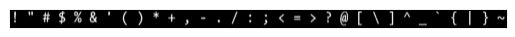

In [63]:
import cv2 as cv
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

img = cv.imread('image3.png', cv.IMREAD_GRAYSCALE)
plt.imshow(img,'gray',vmin=0,vmax=255)
_, thresh1 = cv.threshold(img,127,255,cv.THRESH_BINARY_INV)
thresh1 = sp.ndimage.filters.gaussian_filter(thresh1, (2,0))




plt.imshow(thresh1,'gray',vmin=0,vmax=255)
plt.xticks([]),plt.yticks([])
contours, _ = cv.findContours(thresh1, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)


contours = sorted(contours, key=lambda c: cv.boundingRect(c)[0])
chars = []
for i, c in enumerate(contours):
    x, y, w, h = cv.boundingRect(c)

    char = img[y:y+h, x:x+w]
    chars.append(char)
    path = './saved/' + 'char_'+str(i)+'.png'
    cv.imwrite(path, char)


